In [1]:
import warnings
import numpy as np

# Suppress the specific RuntimeWarning from numpy's subtract function
warnings.filterwarnings(
    'ignore',
    category=RuntimeWarning,
    message='invalid value encountered in subtract',
    module='numpy.lib._function_base_impl'
)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import norm
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from config import ORDER, JOURNAL_MAP

plt.rcParams["font.family"] = "Arial"
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams["text.usetex"] = True

df_sample = pd.read_csv("../data/focal_papers.csv")
df_generated = pd.read_csv("../data/generated_references.csv")
df_ground_truth = pd.read_csv("../data/ground_truth_references.csv")

# existing vs non-existent
df_existing = df_generated[df_generated["Exists"] == 1.0]
df_non_existent = df_generated[df_generated["Exists"] == 0.0]

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_27038/2153734850.py:18: DtypeWarning: Columns (4,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_generated = pd.read_csv("../data/generated_references.csv")


In [3]:
# additional computations

starting_year = 1970

year_mask_gen = df_generated["Publication Year"].apply(
    lambda x: str(x).replace(".", "", 1).isdigit() 
    if not pd.isna(x) else True
)
df_generated.loc[~year_mask_gen, "Publication Year"] = np.nan
df_generated["Publication Year"] = df_generated[
    "Publication Year"
].astype(float)

df_generated["Publication Year_limited"] = df_generated["Publication Year"]
df_generated.loc[
    df_generated["Publication Year_limited"] < starting_year, "Publication Year_limited"
] = starting_year

year_mask_ground = df_ground_truth["Year_x"].apply(
    lambda x: str(x).replace(".", "", 1).isdigit()
    if not pd.isna(x) else True
)
df_ground_truth.loc[~year_mask_ground, "Year_x"] = np.nan
df_ground_truth[
    "Publication Year"
] = df_ground_truth["Year_x"].astype(float)
df_ground_truth["Publication Year_limited"] = df_ground_truth["Publication Year"]
df_ground_truth.loc[
    df_ground_truth["Publication Year_limited"] < starting_year, "Publication Year_limited"
] = starting_year

def extract_top_value(field_types, hit_values):
    if not isinstance(field_types, list) or not isinstance(hit_values, list):
        return None
    try:
        # Find the index of the "Top" field and return the corresponding value
        top_index = field_types.index('Top')
        return float(hit_values[top_index])
    except (ValueError, IndexError):
        return None

df_ground_truth["FieldType_list"] = df_ground_truth["Field_Type"].str.split(", ")
df_ground_truth["Hit1pct_list"] = df_ground_truth["Hit_1pct"].str.split(", ")
df_ground_truth["Hit5pct_list"] = df_ground_truth["Hit_5pct"].str.split(", ")
df_ground_truth["Hit10pct_list"] = df_ground_truth["Hit_10pct"].str.split(", ")
df_ground_truth["Cf_list"] = df_ground_truth["C_f"].str.split(", ")

df_existing['FieldType_list'] = df_existing['FieldType'].str.split(', ')
df_existing['Hit1pct_list'] = df_existing['Hit1pct'].str.split(', ')
df_existing['Hit5pct_list'] = df_existing['Hit5pct'].str.split(', ')
df_existing['Hit10pct_list'] = df_existing['Hit10pct'].str.split(', ')
df_existing['Cf_list'] = df_existing['Cf'].str.split(', ')


df_ground_truth['Top_Hit1pct'] = df_ground_truth.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Hit1pct_list']),
    axis=1
)
df_ground_truth['Top_Hit5pct'] = df_ground_truth.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Hit5pct_list']),
    axis=1
)
df_ground_truth['Top_Hit10pct'] = df_ground_truth.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Hit10pct_list']),
    axis=1
)
df_ground_truth['Top_Cf'] = df_ground_truth.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Cf_list']),
    axis=1
)

df_existing['Top_Hit1pct'] = df_existing.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Hit1pct_list']),
    axis=1
)
df_existing['Top_Hit5pct'] = df_existing.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Hit5pct_list']),
    axis=1
)
df_existing['Top_Hit10pct'] = df_existing.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Hit10pct_list']),
    axis=1
)
df_existing['Top_Cf'] = df_existing.apply(
    lambda row: extract_top_value(row['FieldType_list'], row['Cf_list']),
    axis=1
)

df_citations = pd.concat(
    [
        pd.concat(
            [
                df_ground_truth[["Top_Cf"]]
                .rename(columns={"Top_Cf": "citations"})
                .assign(Type="Top_Cf"),

                df_ground_truth[["C5"]]
                .rename(columns={"C5": "citations"})
                .assign(Type="C5"),

                df_ground_truth[["C10"]]
                .rename(columns={"C10": "citations"})
                .assign(Type="C10"),
            ],
            ignore_index=True  # Reset index here
        ).assign(Category='ground_truth'),
        pd.concat(
            [
                df_existing[["Top_Cf"]]
                .rename(columns={"Top_Cf": "citations"})
                .assign(Type="Top_Cf"),

                df_existing[["C5"]]
                .rename(columns={"C5": "citations"})
                .assign(Type="C5"),

                df_existing[["C10"]]
                .rename(columns={"C10": "citations"})
                .assign(Type="C10"),
            ],
            ignore_index=True  # Reset index here
        ).assign(Category='generated'),
    ],
    ignore_index=True  # Reset index for the final DataFrame
)

df_hits = pd.concat(
    [
        pd.concat(
            [
                df_ground_truth[["Top_Hit1pct"]]
                .rename(columns={"Top_Hit1pct": "hits"})
                .assign(Type="top1"),

                df_ground_truth[["Top_Hit5pct"]]
                .rename(columns={"Top_Hit5pct": "hits"})
                .assign(Type="top5"),

                df_ground_truth[["Top_Hit10pct"]]
                .rename(columns={"Top_Hit10pct": "hits"})
                .assign(Type="top10"),
            ],
            ignore_index=True  # Reset index here
        ).assign(Category='ground_truth'),
        pd.concat(
            [
                df_existing[["Top_Hit1pct"]]
                .rename(columns={"Top_Hit1pct": "hits"})
                .assign(Type="top1"),

                df_existing[["Top_Hit5pct"]]
                .rename(columns={"Top_Hit5pct": "hits"})
                .assign(Type="top5"),

                df_existing[["Top_Hit10pct"]]
                .rename(columns={"Top_Hit10pct": "hits"})
                .assign(Type="top10"),
            ],
            ignore_index=True  # Reset index here
        ).assign(Category='generated'),
    ],
    ignore_index=True  # Reset index for the final DataFrame
)

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_27038/1302861024.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_existing['FieldType_list'] = df_existing['FieldType'].str.split(', ')
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_27038/1302861024.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_existing['Hit1pct_list'] = df_existing['Hit1pct'].str.split(', ')
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_27038/1302861024.py:50: SettingWithCopyWarning: 
A va

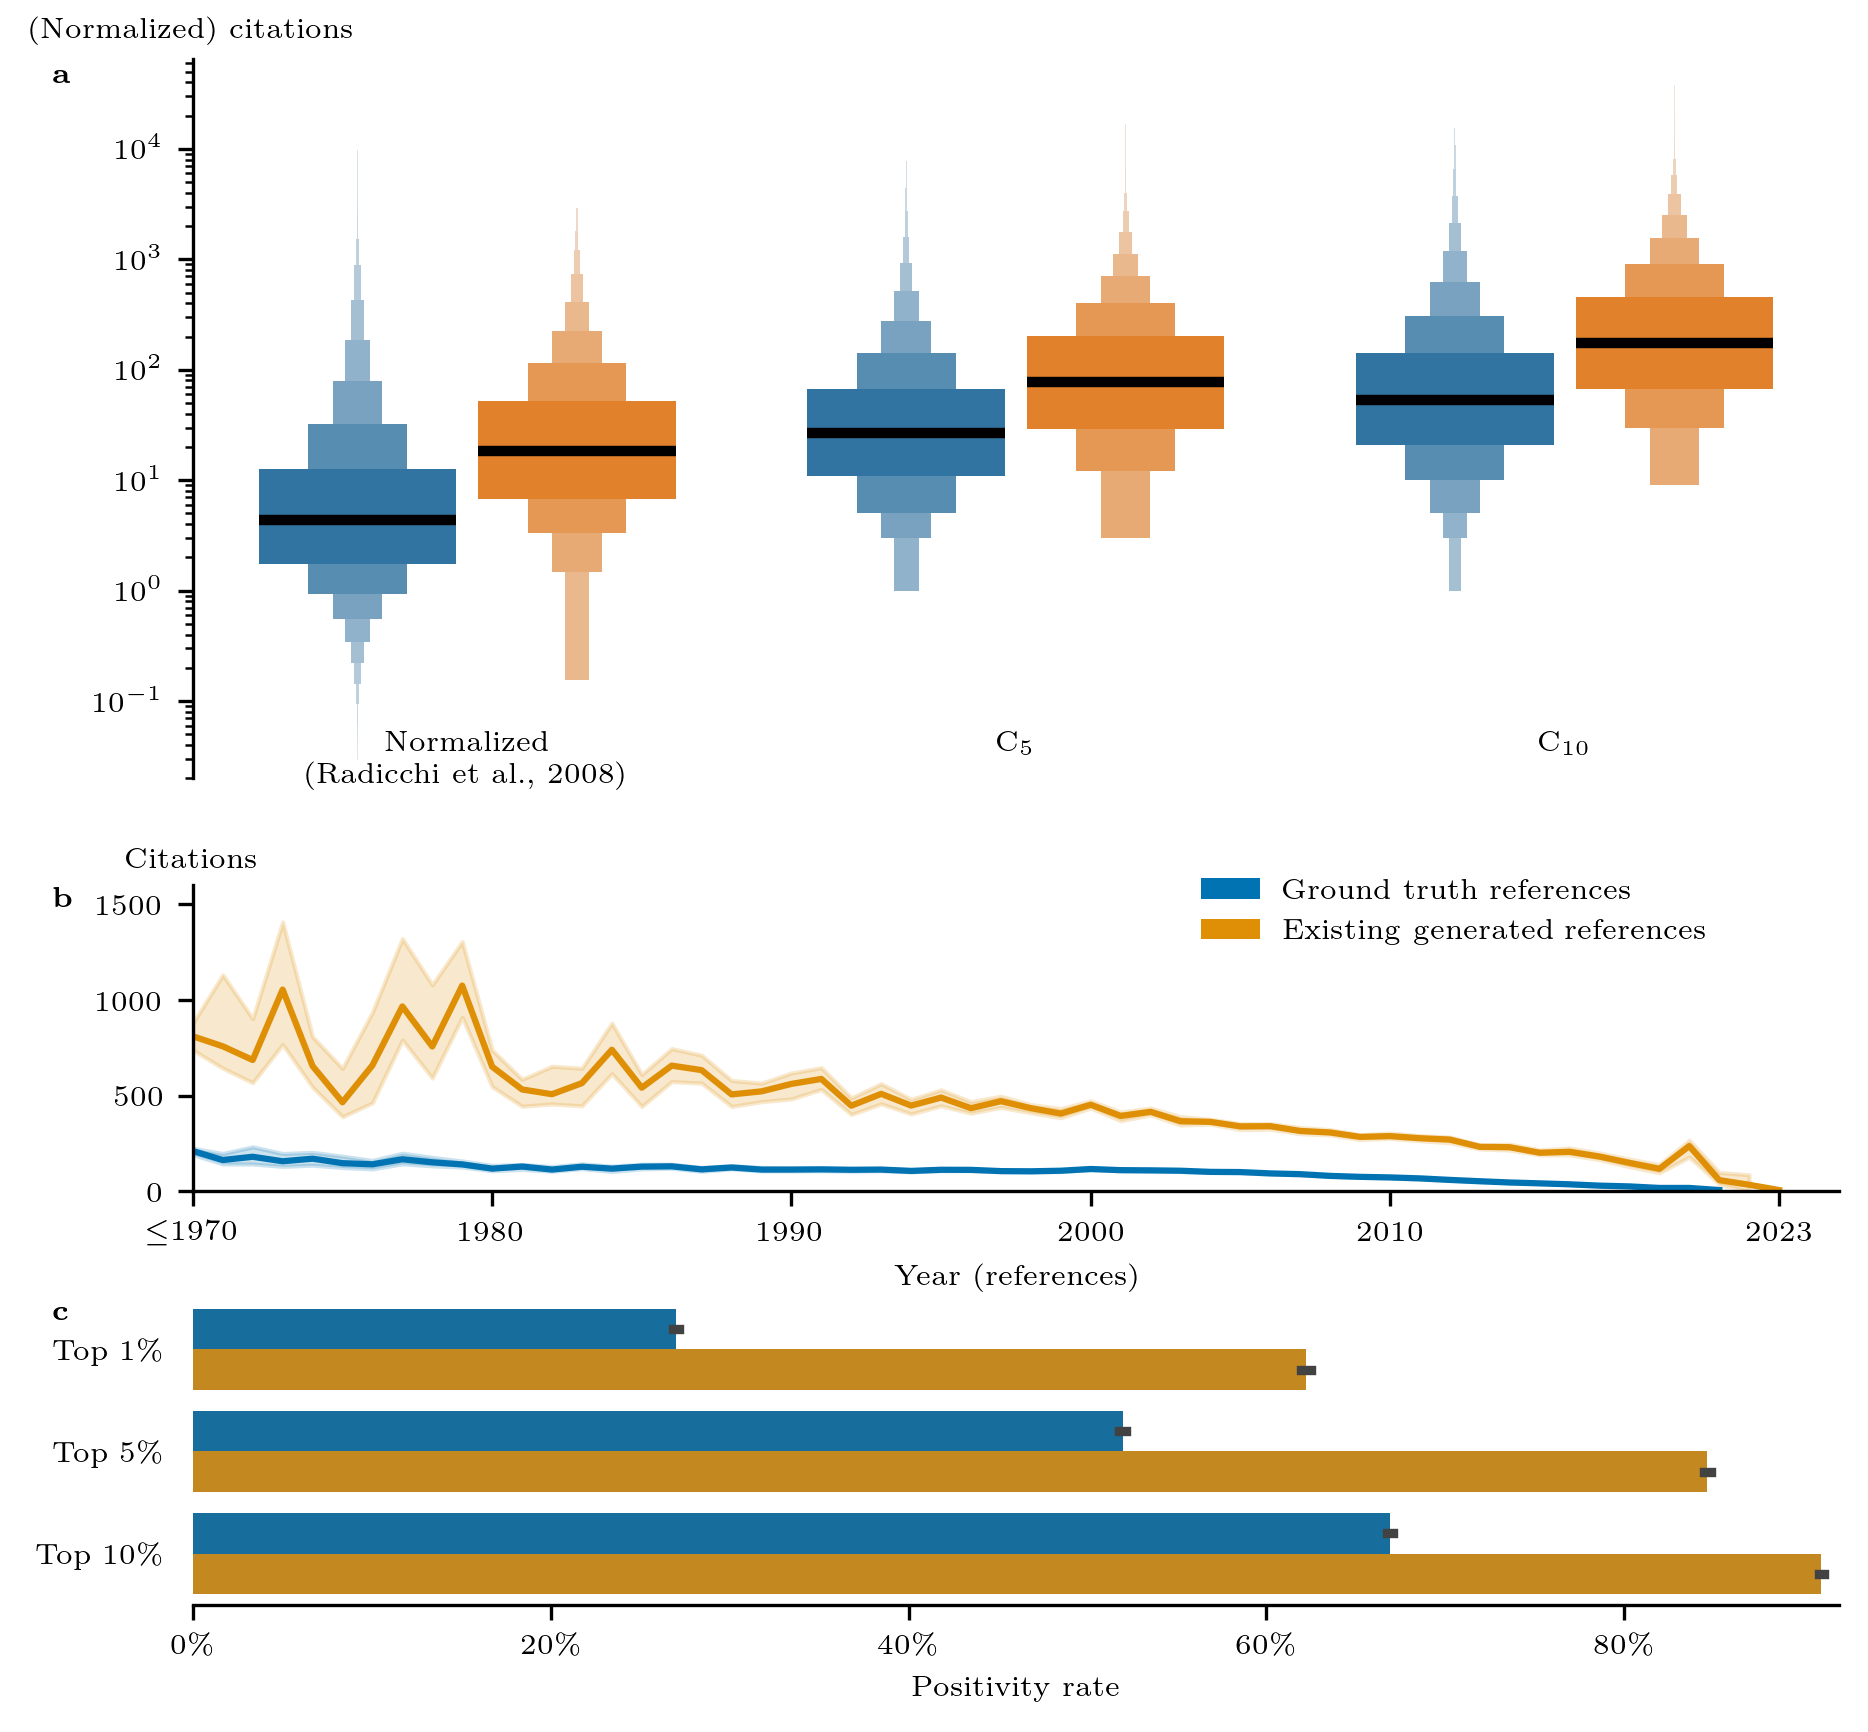

In [4]:
Figure1, ax1 = plt.subplot_mosaic(
    [
        ['A'],
        ['A'],
        ['C'],
        ['B'],
    ],
    figsize=(7.08, 6.69),
    dpi=300,
    gridspec_kw={'wspace': 0.2, 'hspace': 0.35},  # Adjust spacing
)

# A
sns.boxenplot(
    data=df_citations,
    y='citations',
    x='Type',
    hue='Category',
    # orient='h',
    log_scale=True,
    # palette=["#0173b2", "#de8f05", "#0173b2", "#de8f05"],
    # hue_order=['ground_truth_journal', 'generated_journal', 'ground_truth_book', 'generated_book'],
    gap=0.1,
    edgecolor=None,
    linecolor='black',
    linewidth=2,
    showfliers=False,
    legend=False,
    ax=ax1['A'],
)

ax1["A"].set_title("")
ax1["A"].set_ylim(0.02, 65000)
ax1["A"].set_xlabel("", fontsize=7)
ax1["A"].set_ylabel("(Normalized) citations", fontsize=7, rotation=0)
ax1["A"].yaxis.set_label_coords(0., 1.02)
ax1["A"].set_yticks(
    ticks=[0.1, 1, 10, 100, 1000, 10000],
    labels=[r"$10^{-1}$", r"$10^0$", r"$10^1$", "$10^2$", "$10^3$", "$10^4$"],
    fontsize=7
)
ax1["A"].set_xticks(
    [0, 1, 2],
    labels=["Normalized\n(Radicchi et al., 2008)", r"$\mathrm{C}_5$", r"$\mathrm{C}_{10}$"],
    fontsize=7,
)
ax1["A"].xaxis.set_tick_params(pad=-15)

ax1["A"].tick_params(bottom=False)
sns.despine(ax=ax1["A"], left=False, bottom=True)

# C
sns.lineplot(
    df_ground_truth,
    x="Publication Year_limited",
    y="Citation_Count_x",
    color='#0173b2',
    linewidth=1.5,
    estimator="median",
    ax=ax1["C"],
)

sns.lineplot(
    df_generated[df_generated["Exists"] == 1],
    x="Publication Year_limited",
    y="Citations",
    color='#de8f05',
    linewidth=1.5,
    estimator="median",
    ax=ax1["C"],
)

ax1["C"].set(xlim=(starting_year, 2025))
ax1["C"].set_xlabel("Year (references)", fontsize=7)
ax1["C"].set_ylabel("Citations", fontsize=7, rotation=0)
ax1["C"].yaxis.set_label_coords(0.0, 1.04)
ax1["C"].set_xticks(
    ticks=[1970, 1980, 1990, 2000, 2010, 2023],
    labels=[r"$\small\leq$1970", "1980", "1990", "2000", "2010", "2023"],
    fontsize=7,
)
ax1["C"].set_yticks(
    [0, 500, 1000, 1500],
    labels=["0","500", "1000", "1500"],
    fontsize=7,
)
ax1["C"].set_title("")

ax1["C"].set(ylim=(0, 1600))

sns.despine(ax=ax1["C"],left=False, bottom=False)

# B
sns.barplot(
    df_hits,
    x="hits",
    y="Type",
    hue="Category",
    palette=["#0173b2", "#de8f05"],
    estimator="mean",
    legend=False,
    ax=ax1["B"],
)

ax1["B"].tick_params(left=False)
ax1["B"].set_xlabel("Positivity rate", fontsize=7)
ax1["B"].set(xlim=(0, 0.92))
ax1["B"].set_ylabel("", fontsize=7)
ax1["B"].set_yticks(
    ticks=[0, 1, 2],
)
ax1["B"].set_yticklabels(
    labels=[r"Top $1\%$", r"Top $5\%$", r"Top $10\%$"],
    fontsize=7,
)
ax1["B"].set_xticks(
    [0,0.20,0.40,0.60,0.80],
    labels=[r"0$\%$",r"20$\%$",r"40$\%$",r"60$\%$",r"80$\%$"],
    fontsize=7,
)
ax1["B"].set_title("")
ax1["B"].grid(False)

sns.despine(ax=ax1["B"],left=True, bottom=False)

# legend
legend_elements = [
    Patch(facecolor='#0173b2', edgecolor=None, label='Ground truth references'),
    Patch(facecolor='#de8f05', edgecolor=None, label='Existing generated references'),
]

ax1["B"].legend(
    handles=legend_elements,
    loc='upper right',
    title='',
    title_fontsize=7,
    fontsize=7,
    frameon=False,
    bbox_transform=Figure1.transFigure,
    bbox_to_anchor=(0.85, 0.485),
)

# annotations
annotations = {
    'A': r'\textbf{a}',
    'B': r'\textbf{c}',
    'C': r'\textbf{b}',
}

# Annotate each subplot
for key, ax in ax1.items():
    ax.text(-0.085, 0.995, annotations[key], transform=ax.transAxes, 
            fontsize=7, fontweight='bold', va='top', ha='left')